In [7]:
import glob, matplotlib, re
# The uproot module is needed to convert the standard CERN file format (called "ROOT") to pandas dataframes.
import uproot, pandas
import numpy as np

# Beautification of plot utilities
from plotParams import varLabels, binnings, units

randomState = 5

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
tf.random.set_seed(1984)

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
font = {'size':14}
matplotlib.rc('font', **font)

In [92]:
# The samples are in the standard file format used at CERN: ROOT.
# We will convert these to pandas dataframes with the uproot package.

# We will consider two new physics models (signal 700_400 and 1300_1) and the background.
# The desired outcome is that when we cluster these we will get three clusters: one for 1300_1, one 700_400, and one for background.
sigPath='/data/atlasfs02/a/users/whopkins/SheffieldNtuples_v21.2.71-SRABC-PostFAR-Signals/'
sigPaths = glob.glob(sigPath+'*TT_directTT_1300_1.*10201*p3712*')
sigPaths.extend(glob.glob(sigPath+'*TT_directTT_700_400.e6985_a875_r10201_p3712*'))
sigPaths.extend(glob.glob(sigPath+'*TT_directTT_1200_1.e6985_a875_r10201_p3712*'))
bkgPaths = glob.glob('/data/atlasfs02/a/users/whopkins/SheffieldNtuples_SRABC/*10201*.root')
treeName='NominalFixed'

# Only select variables that were used in the original signal regions that searched for these signals on ATLAS.
from stop0L import selections
srList = ['SRATT', 'SRATW', 'SRAT0', 'SRBTT', 'SRBTW', 'SRBT0']#, 'SRC1_5']
splitPat = '[><=]'
allCuts = []
for sr in srList:
    allCuts.extend([re.split(splitPat, cut.replace('(', '').replace(')', ''))[0].rstrip().lstrip() for cut in selections[sr].split("*")])
branches = sorted(list(set(allCuts)))
branches.append('pT_1jet')

# These branches are needed to weight the different components of the background correctly.
# In the end we will weight background and the two signals so that they have the same integral.
branches.append('LumiWeight')
branches.append('AnalysisWeight')

print(branches)

# Give the signal samples a reasonable name
sampLabels = []
for path in sigPaths:
    fName = path.split('/')[-1]
    
    firstSplitStr = 'directTT_';
    secondSplitStr = '.'
    if 'bWN' in fName:
        firstSplitStr = 'bWN_';
        secondSplitStr = '_Mad'
    sampLabels.append('sig_'+fName.split(firstSplitStr)[1].split(secondSplitStr)[0])

print('All available variables')

sigData = {}
# The lumi is technically not needed here since we will rescale everything anyway.
# However, it is useful for comparing the original analysis (manually designed) with
# the result of the k-means (can k-means separate the samples as strongly as we can?).
lumi = 139000
for path, sampName in zip(sigPaths, sampLabels):
    tree = uproot.open(path)[treeName]
    data = tree.arrays(branches, library='pd')
    data['sampName'] = sampName
    data['weight'] = data['AnalysisWeight']*data['LumiWeight']*lumi
    sigData[sampName] = data

bkgData = []
weights = []
for path in bkgPaths:
    fName = path.split('/')[-1]
    sampName = fName.split('.')[2]
    inF = uproot.open(path)
    tree = inF[treeName]
    if 'pT_1jet' not in sorted(tree.keys()):
        continue
    data = tree.arrays(branches, library='pd')
    data['weight'] = data['AnalysisWeight']*data['LumiWeight']*lumi
    data['sampName'] = 'bkg'
    bkgData.append(data)
dataList = list(sigData.values())
dataList.extend(bkgData)

allSamps = pandas.concat(dataList)
sampLabels.append('bkg')
print(sampLabels)

['MT2Chi2', 'MTbmax', 'MTbmin', 'dRb1b2', 'dphimin4', 'eT_miss', 'flav_1fatjet_kt12', 'flav_2fatjet_kt12', 'm_1fatjet_kt12', 'm_1fatjet_kt8', 'm_2fatjet_kt12', 'metsigST', 'nbaselineLep', 'nj_good', 'num_bjets', 'pT_2jet', 'pT_4jet', 'passMETtriggers', 'passtauveto', 'pT_1jet', 'LumiWeight', 'AnalysisWeight']
All available variables


['sig_1300_1', 'sig_700_400', 'sig_1200_1', 'bkg']


In [93]:
vetoList=['passMETtriggers', 'passtauveto', 'nbaselineLep', 'eT_miss', 
          'flav_1fatjet_kt12', 'flav_2fatjet_kt12', 'num_bjets', 'NbV', 'NjV', 'nj_good']
trainBranches = [branch for branch in branches if branch not in vetoList]
print(trainBranches)
trainBranches = ['metsigST']#['dRb1b2']#, 'metsigST',]

['MT2Chi2', 'MTbmax', 'MTbmin', 'dRb1b2', 'dphimin4', 'm_1fatjet_kt12', 'm_1fatjet_kt8', 'm_2fatjet_kt12', 'metsigST', 'pT_2jet', 'pT_4jet', 'pT_1jet', 'LumiWeight', 'AnalysisWeight']


In [94]:
sigTestSamp = allSamps[allSamps.sampName=='sig_1300_1'][trainBranches].to_numpy()
testTrainFrac = 0.5
nEvents = sigTestSamp.shape[0]
msk = np.random.choice(np.arange(nEvents), size=int(nEvents*testTrainFrac), replace=False)
xTrain = sigTestSamp[msk]
xTest = sigTestSamp[~msk]
yTrain = sigTestSamp[msk]
yTest = sigTestSamp[~msk]

In [95]:
import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

<Figure size 640x480 with 0 Axes>

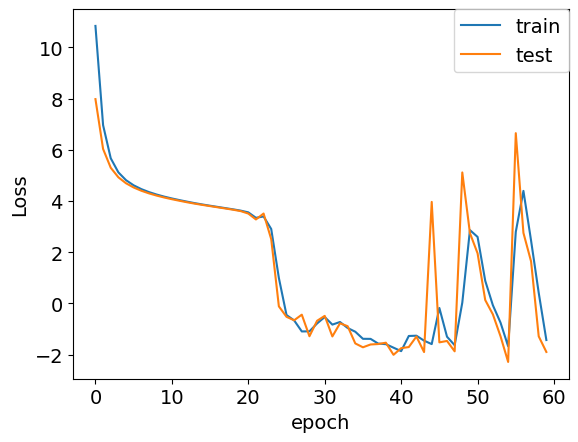

In [108]:
event_shape = yTrain.shape[1]
epochs = 60
batchSize = 100
num_components = 10
params_size = tfpl.MixtureNormal.params_size(num_components, event_shape=event_shape)
model = tfk.Sequential([
    tfkl.InputLayer(input_shape=(len(trainBranches),)),
    tfkl.Dense(100, activation='relu'),
    tfkl.Dense(params_size, activation=None),
    tfpl.MixtureNormal(num_components, event_shape=event_shape)
])
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
             loss=lambda y, model: -model.log_prob(y))
history = model.fit(xTrain, yTrain, epochs=epochs, batch_size=batchSize, shuffle=True, validation_data=(xTest, yTest),
                    verbose=False)
plt.clf()
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('Loss')
leg = plt.legend(['train', 'test'], loc=0, borderaxespad=0.)
plt.savefig('loss.pdf', bbox_inches='tight')

In [109]:
yPredTest = model.predict(xTest)
yPredTrain = model.predict(xTrain)

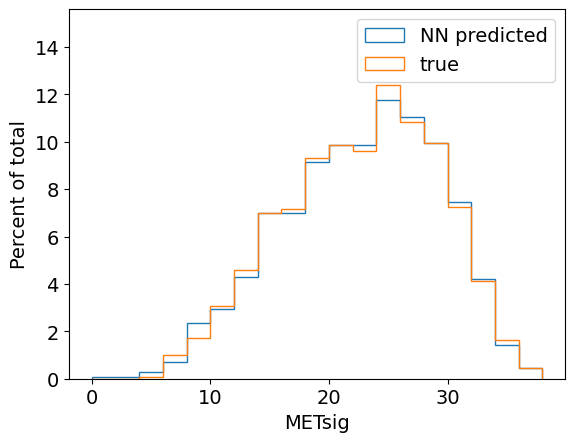

In [110]:
binning = [i*2 for i in range(20)]
fig, ax = plt.subplots()
a = plt.hist(yPredTest, bins=binning, weights=100*np.ones(yPredTest.shape[0])/yPredTest.shape[0], histtype='step', label='NN predicted')
a = plt.hist(yTest, bins=binning, weights=100*np.ones(yTest.shape[0])/yTest.shape[0], histtype='step', label='true')
#plt.yscale('log')
ax.set_xlabel('METsig')
ax.set_ylabel('Percent of total')
ax.set_ylim([0, ax.get_ylim()[1]*1.2])

ax.legend(loc=0)
plt.savefig(f'testShape.pdf', bbox_inches='tight')
plt.savefig(f'testShape.svg', bbox_inches='tight')
plt.savefig(f'testShape.png', bbox_inches='tight')

No handles with labels found to put in legend.


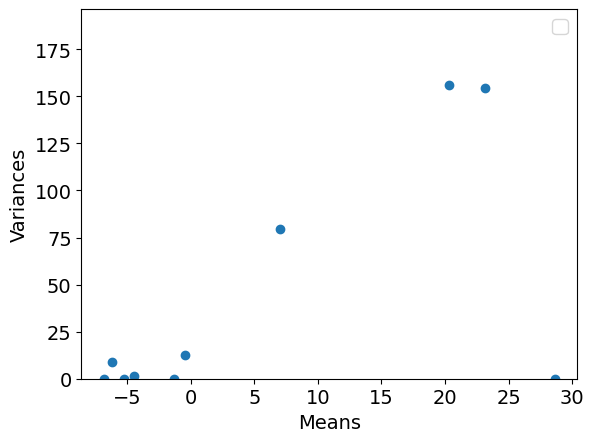

In [111]:
x_star = xTrain[0]
model_star = model(np.array([x_star]))
amps = np.array(model_star.mixture_distribution.probs_parameter()).flatten()
means = np.array(model_star.components_distribution.mean()).flatten()
variances = np.array(model_star.components_distribution.variance()).flatten()
fig, ax = plt.subplots()
plt.scatter(means, variances)
ax.set_xlabel('Means')
ax.set_ylabel('Variances')
ax.set_ylim([0, ax.get_ylim()[1]*1.2])

ax.legend(loc=0)
plt.savefig(f'means_variances.pdf', bbox_inches='tight')
plt.savefig(f'means_variances.svg', bbox_inches='tight')
plt.savefig(f'means_variances.png', bbox_inches='tight')

In [113]:
sigTestSamp = allSamps[allSamps.sampName=='sig_1200_1'][trainBranches].to_numpy()
testTrainFrac = 0.5
nEvents = sigTestSamp.shape[0]
msk = np.random.choice(np.arange(nEvents), size=int(nEvents*testTrainFrac), replace=False)
xTrain = sigTestSamp[msk]
xTest = sigTestSamp[~msk]
yTrain = sigTestSamp[msk]
yTest = sigTestSamp[~msk]

<Figure size 640x480 with 0 Axes>

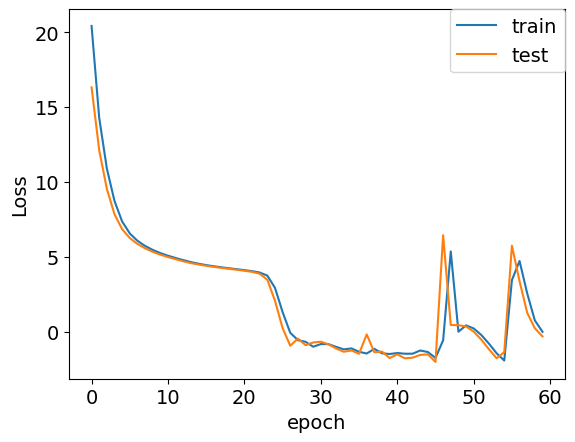

In [114]:
event_shape = yTrain.shape[1]
epochs = 60
batchSize = 100
num_components = 10
params_size = tfpl.MixtureNormal.params_size(num_components, event_shape=event_shape)
model2 = tfk.Sequential([
    tfkl.InputLayer(input_shape=(len(trainBranches),)),
    tfkl.Dense(100, activation='relu'),
    tfkl.Dense(params_size, activation=None),
    tfpl.MixtureNormal(num_components, event_shape=event_shape)
])
model2.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
             loss=lambda y, model2: -model2.log_prob(y))
history = model2.fit(xTrain, yTrain, epochs=epochs, batch_size=batchSize, shuffle=True, validation_data=(xTest, yTest),
                    verbose=False)
plt.clf()
fig, ax = plt.subplots()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
ax.set_xlabel('epoch')
ax.set_ylabel('Loss')
leg = plt.legend(['train', 'test'], loc=0, borderaxespad=0.)
plt.savefig('loss.pdf', bbox_inches='tight')

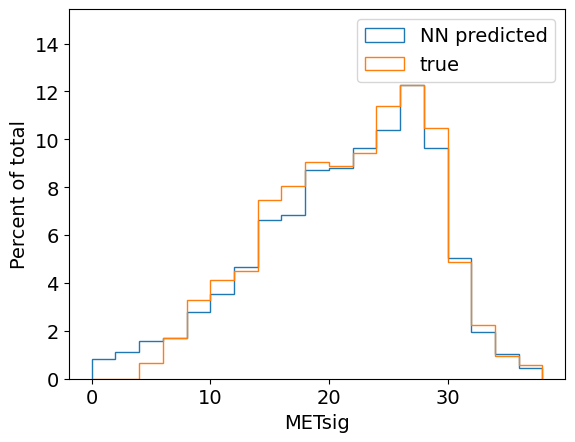

In [115]:
yPredTest = model2.predict(xTest)
yPredTrain = model2.predict(xTrain)
binning = [i*2 for i in range(20)]
fig, ax = plt.subplots()
a = plt.hist(yPredTest, bins=binning, weights=100*np.ones(yPredTest.shape[0])/yPredTest.shape[0], histtype='step', label='NN predicted')
a = plt.hist(yTest, bins=binning, weights=100*np.ones(yTest.shape[0])/yTest.shape[0], histtype='step', label='true')
#plt.yscale('log')
ax.set_xlabel('METsig')
ax.set_ylabel('Percent of total')
ax.set_ylim([0, ax.get_ylim()[1]*1.2])

ax.legend(loc=0)
plt.savefig(f'testShape2.pdf', bbox_inches='tight')
plt.savefig(f'testShape2.svg', bbox_inches='tight')
plt.savefig(f'testShape2.png', bbox_inches='tight')

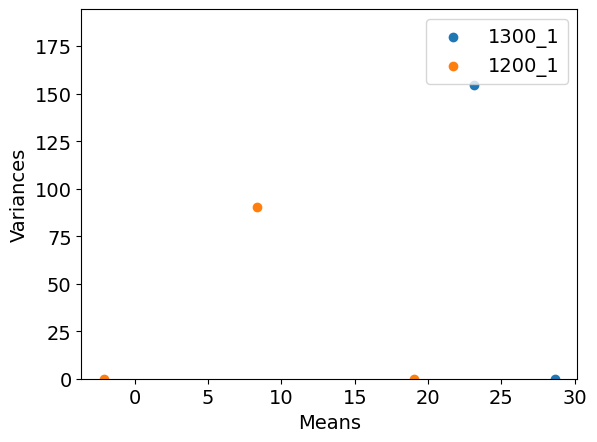

In [120]:
x_star = xTrain[0]
model2_star = model2(np.array([x_star]))
amps2 = np.array(model2_star.mixture_distribution.probs_parameter()).flatten()
goodAmps = amps >.001
goodAmps2 = amps2 >.001
means2 = np.array(model2_star.components_distribution.mean()).flatten()
variances2 = np.array(model2_star.components_distribution.variance()).flatten()
fig, ax = plt.subplots()
plt.scatter(means[goodAmps], variances[goodAmps], label='1300_1')
plt.scatter(means2[goodAmps2], variances2[goodAmpsxs2], label='1200_1')

ax.set_xlabel('Means')
ax.set_ylabel('Variances')
ax.set_ylim([0, ax.get_ylim()[1]*1.2])

ax.legend(loc=0)
plt.savefig(f'means_variances_comp.pdf', bbox_inches='tight')
plt.savefig(f'means_variances_comp.svg', bbox_inches='tight')
plt.savefig(f'means_variances_comp.png', bbox_inches='tight')